In [1]:
cd ..

/home/max/Documents/mgr


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics

from src.generate import load_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *

In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)

emb_size = 10
hidden_size = 16
epoch_count = 15
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)
trained_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')

train_logger = train(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count, batch_size=batch_size)

created reasoner with 3293 parameters
created 40 encoders with 1270 parameters each
train epoch 00/15 | batch 2001/2000 | loss 0.7203 | val loss 0.7208 | acc 0.2127 | f1 0.3507 | prec 0.2127 | recall 0.9977 | roc auc 0.5263 | pr auc 0.2339 | elapsed 14.65s
train epoch 01/15 | batch 2001/2000 | loss 0.5701 | val loss 0.4884 | acc 0.8071 | f1 0.1788 | prec 0.9628 | recall 0.0985 | roc auc 0.6500 | pr auc 0.4169 | elapsed 45.00s
train epoch 02/15 | batch 2001/2000 | loss 0.4398 | val loss 0.3980 | acc 0.8353 | f1 0.4380 | prec 0.8030 | recall 0.3012 | roc auc 0.8089 | pr auc 0.6406 | elapsed 45.08s
train epoch 03/15 | batch 2001/2000 | loss 0.3353 | val loss 0.3253 | acc 0.8793 | f1 0.6508 | prec 0.8490 | recall 0.5276 | roc auc 0.8653 | pr auc 0.7632 | elapsed 44.97s
train epoch 04/15 | batch 2001/2000 | loss 0.2613 | val loss 0.2794 | acc 0.9087 | f1 0.7500 | prec 0.9005 | recall 0.6425 | roc auc 0.8921 | pr auc 0.8212 | elapsed 43.44s
train epoch 05/15 | batch 2001/2000 | loss 0.2159 |

In [4]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
random_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner), ('random reasoner', random_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    train(data_te, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner
train epoch 00/10 | batch 1251/1250 | loss 1.3762 | val loss 1.3762 | acc 0.5908 | f1 0.4043 | prec 0.2958 | recall 0.6387 | roc auc 0.6737 | pr auc 0.4916 | elapsed 10.81s
train epoch 01/10 | batch 1251/1250 | loss 1.1162 | val loss 0.8434 | acc 0.7027 | f1 0.4897 | prec 0.3906 | recall 0.6559 | roc auc 0.7563 | pr auc 0.5832 | elapsed 21.48s
train epoch 02/10 | batch 1251/1250 | loss 0.6861 | val loss 0.5182 | acc 0.8030 | f1 0.6019 | prec 0.5368 | recall 0.6850 | roc auc 0.8329 | pr auc 0.6953 | elapsed 21.21s
train epoch 03/10 | batch 1251/1250 | loss 0.4375 | val loss 0.3438 | acc 0.8720 | f1 0.7078 | prec 0.7025 | recall 0.7131 | roc auc 0.8880 | pr auc 0.7973 | elapsed 21.18s
train epoch 04/10 | batch 1251/1250 | loss 0.3070 | val loss 0.2540 | acc 0.9100 | f1 0.7816 | prec 0.8270 | recall 0.7409 | roc auc 0.9226 | pr auc 0.8629 | elapsed 21.38s
train epoch 05/10 | batch 1251/1250 | loss 0.2379 | val loss 0.2040 | acc 0.9297 | f1 0.8250 | prec 0.8999 | recall 0.

In [5]:
with T.no_grad():
    idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch(trained_reasoner, trained_test_encoders['trained reasoner'], X_te, y_te, idx_te)
    _, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20220715T194304


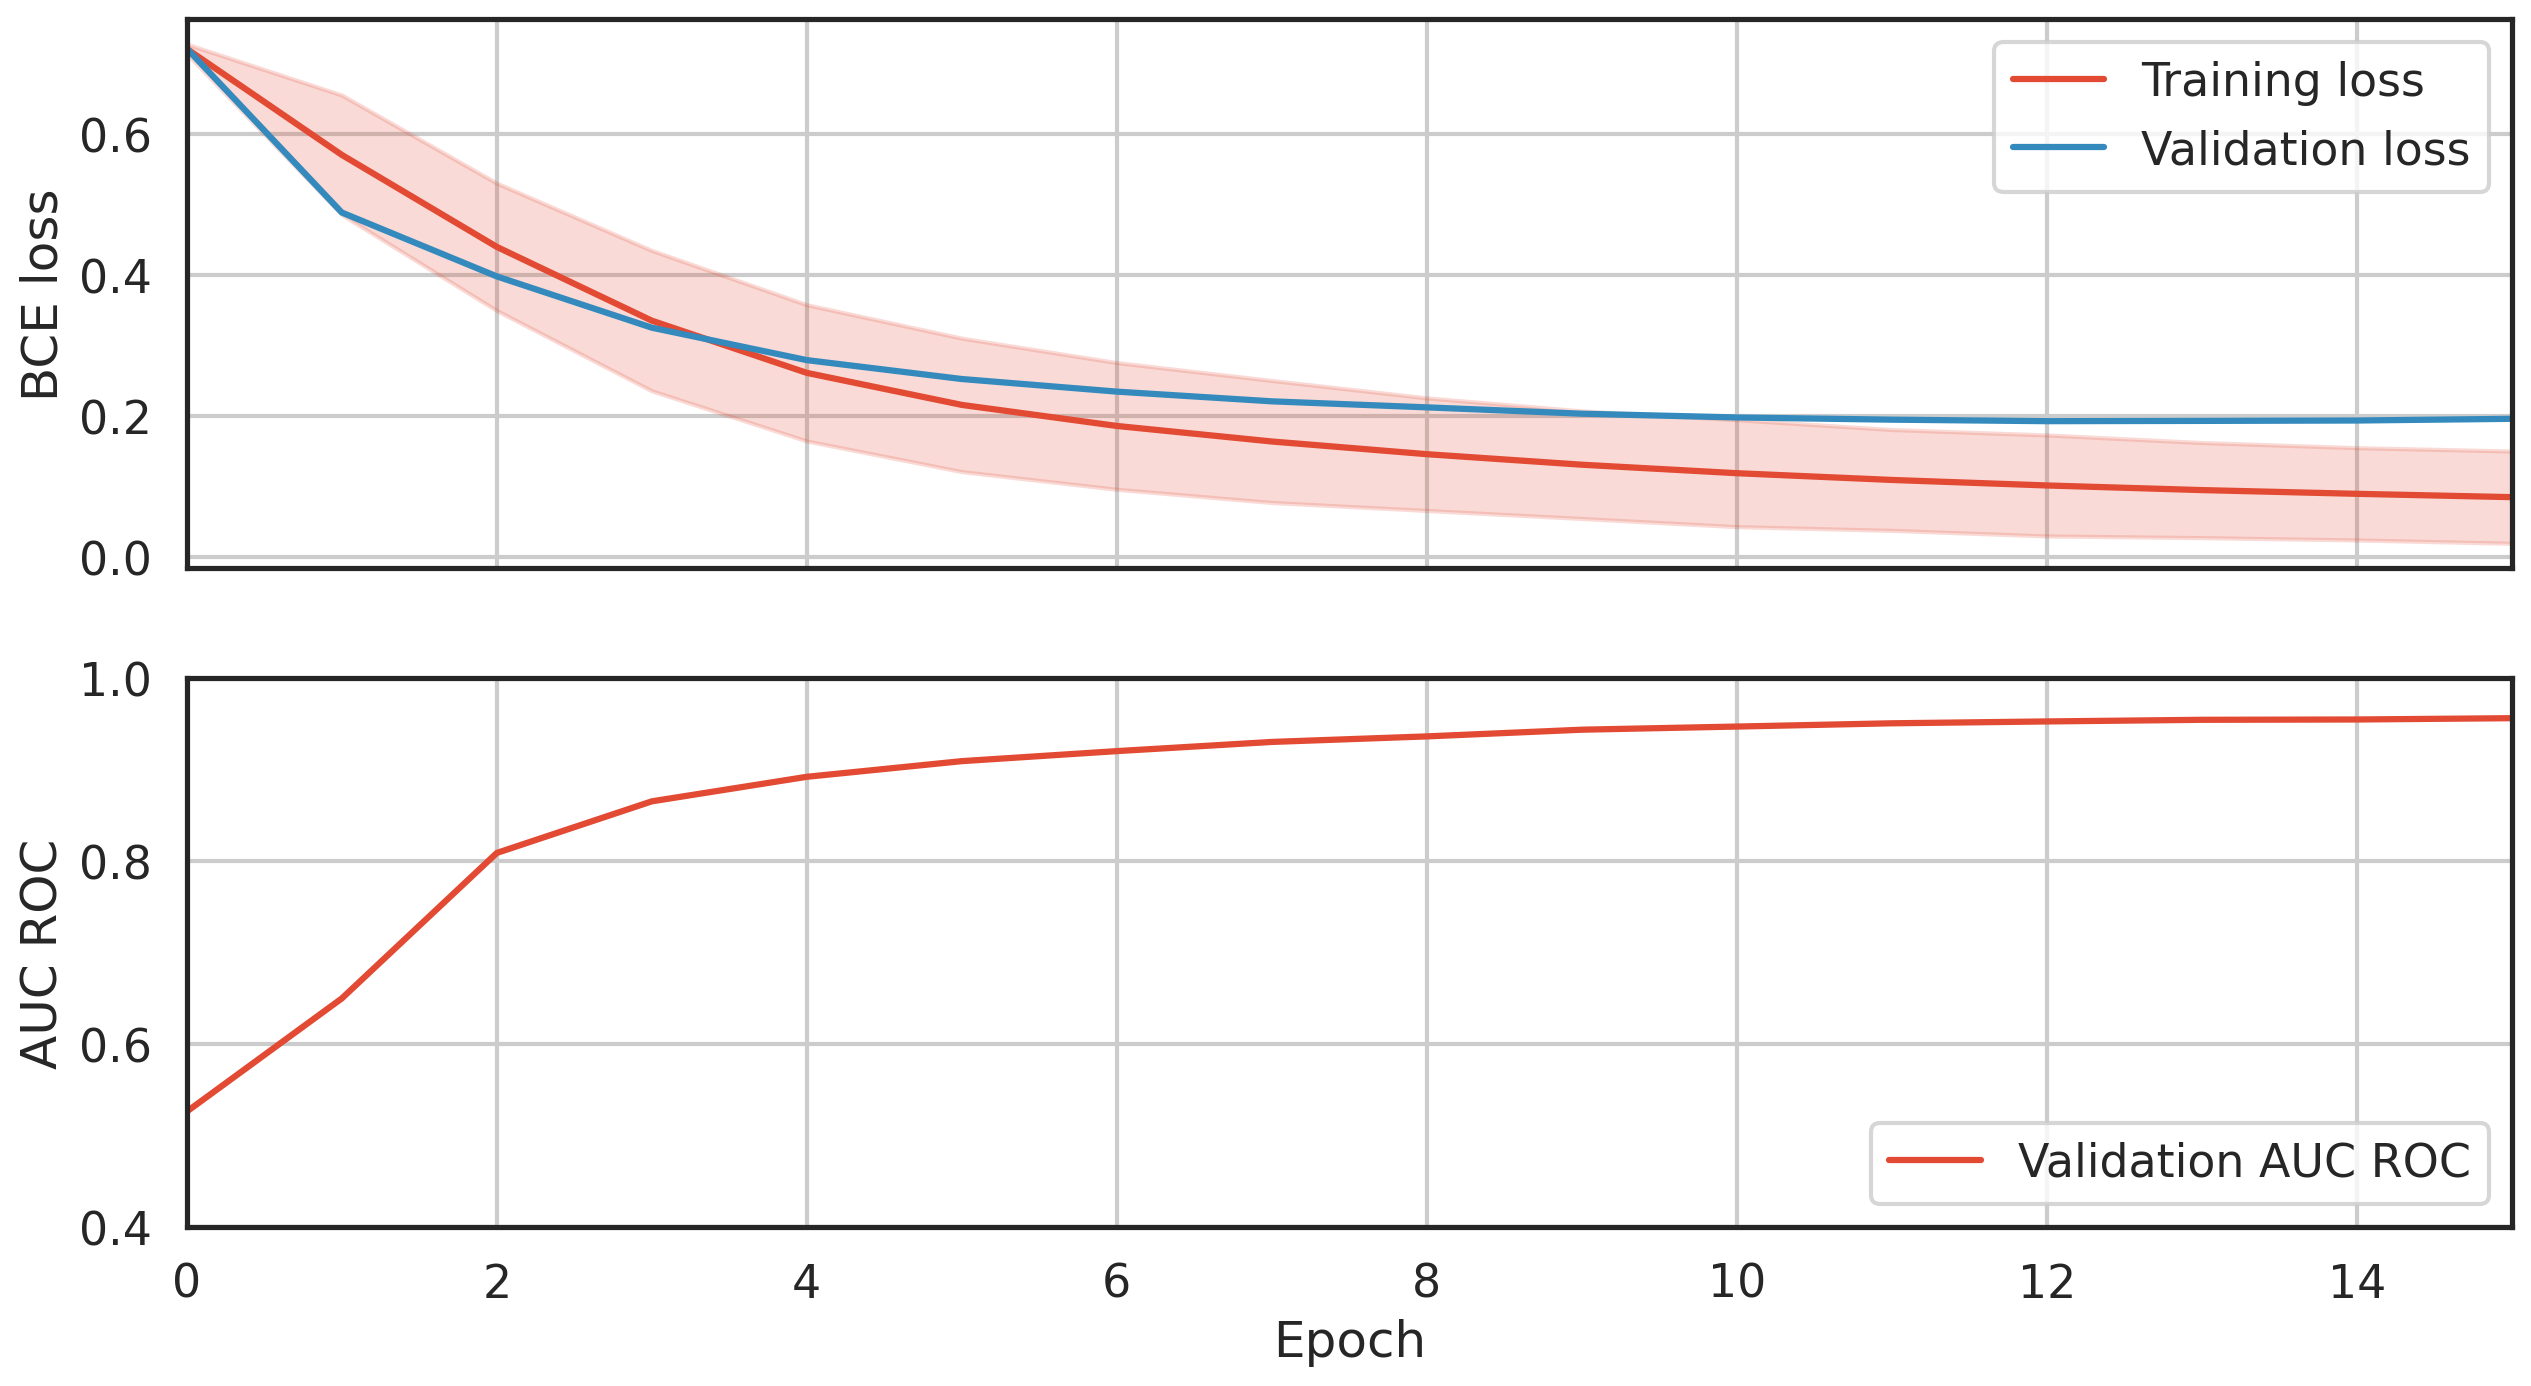

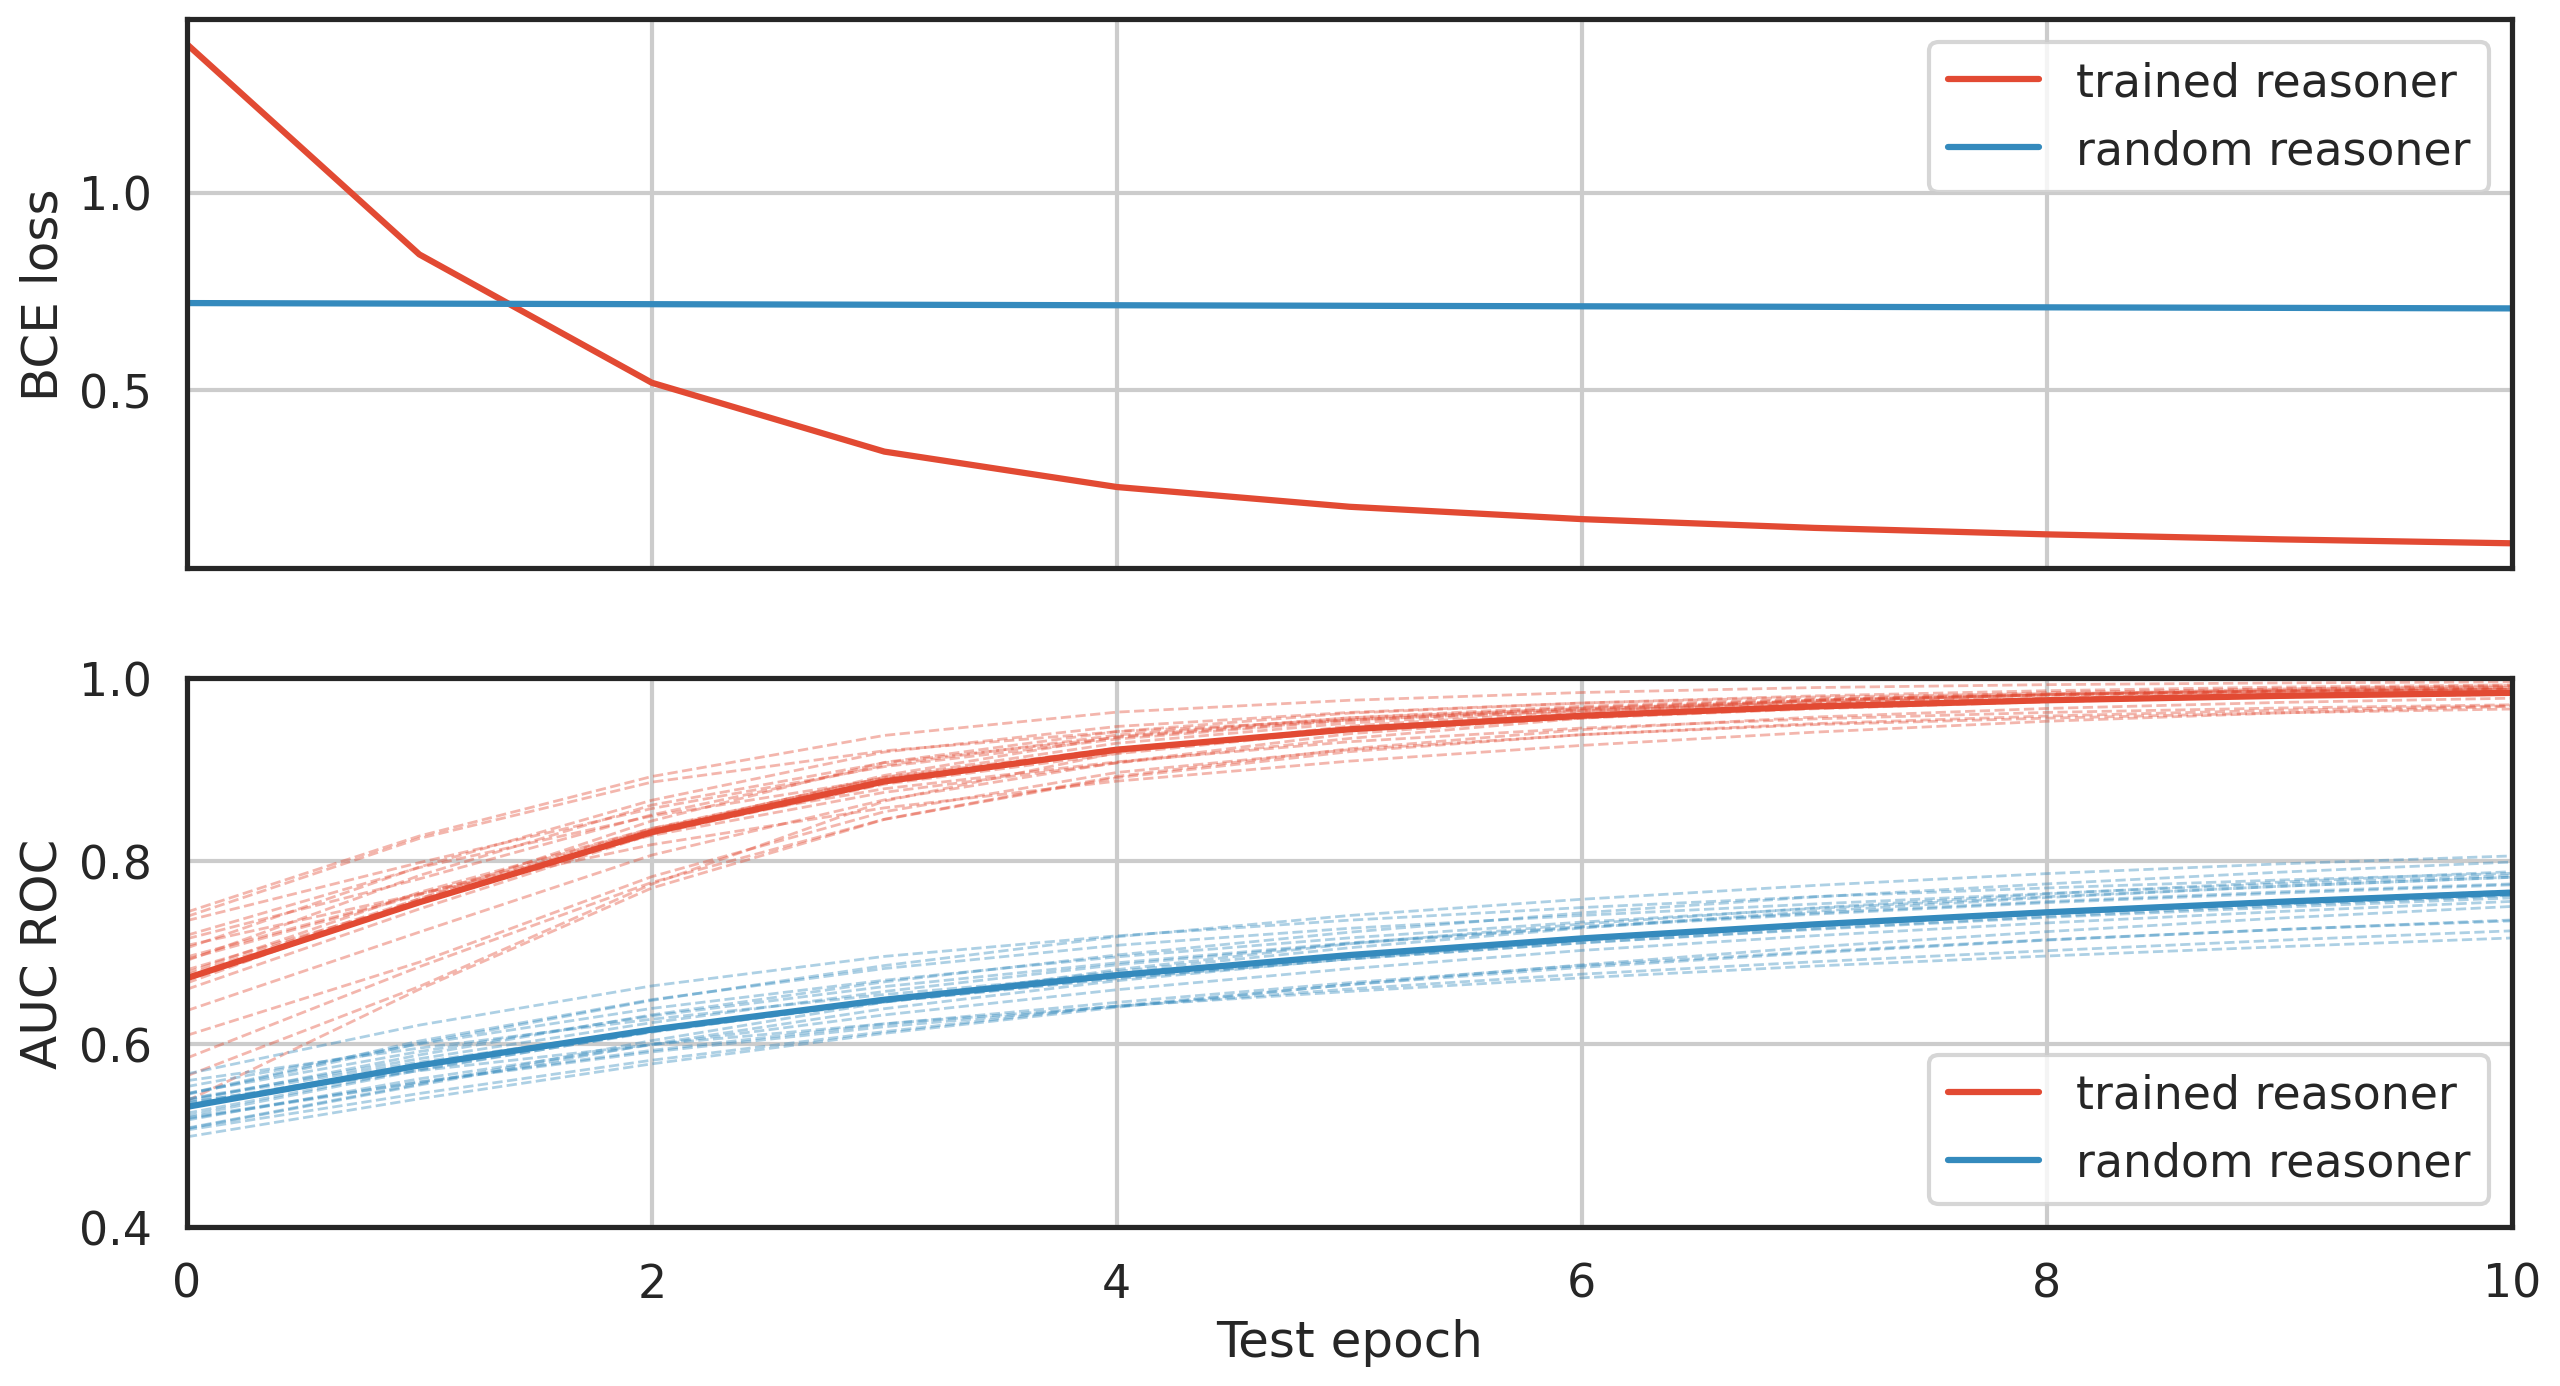

             mean       std     micro
acc      0.961075  0.014886  0.961075
prec     0.969063  0.024949  0.968992
recall   0.846996  0.044665  0.848091
f1       0.903647  0.034671  0.904520
auc_roc  0.983833  0.008646  0.984915
auc_pr   0.964273  0.018430  0.966513
             mean       std     micro
acc      0.287375  0.027590  0.287375
prec     0.231894  0.030550  0.232159
recall   0.987012  0.012017  0.987236
f1       0.374628  0.039972  0.375917
auc_roc  0.765613  0.024267  0.766383
auc_pr   0.558881  0.052247  0.563443


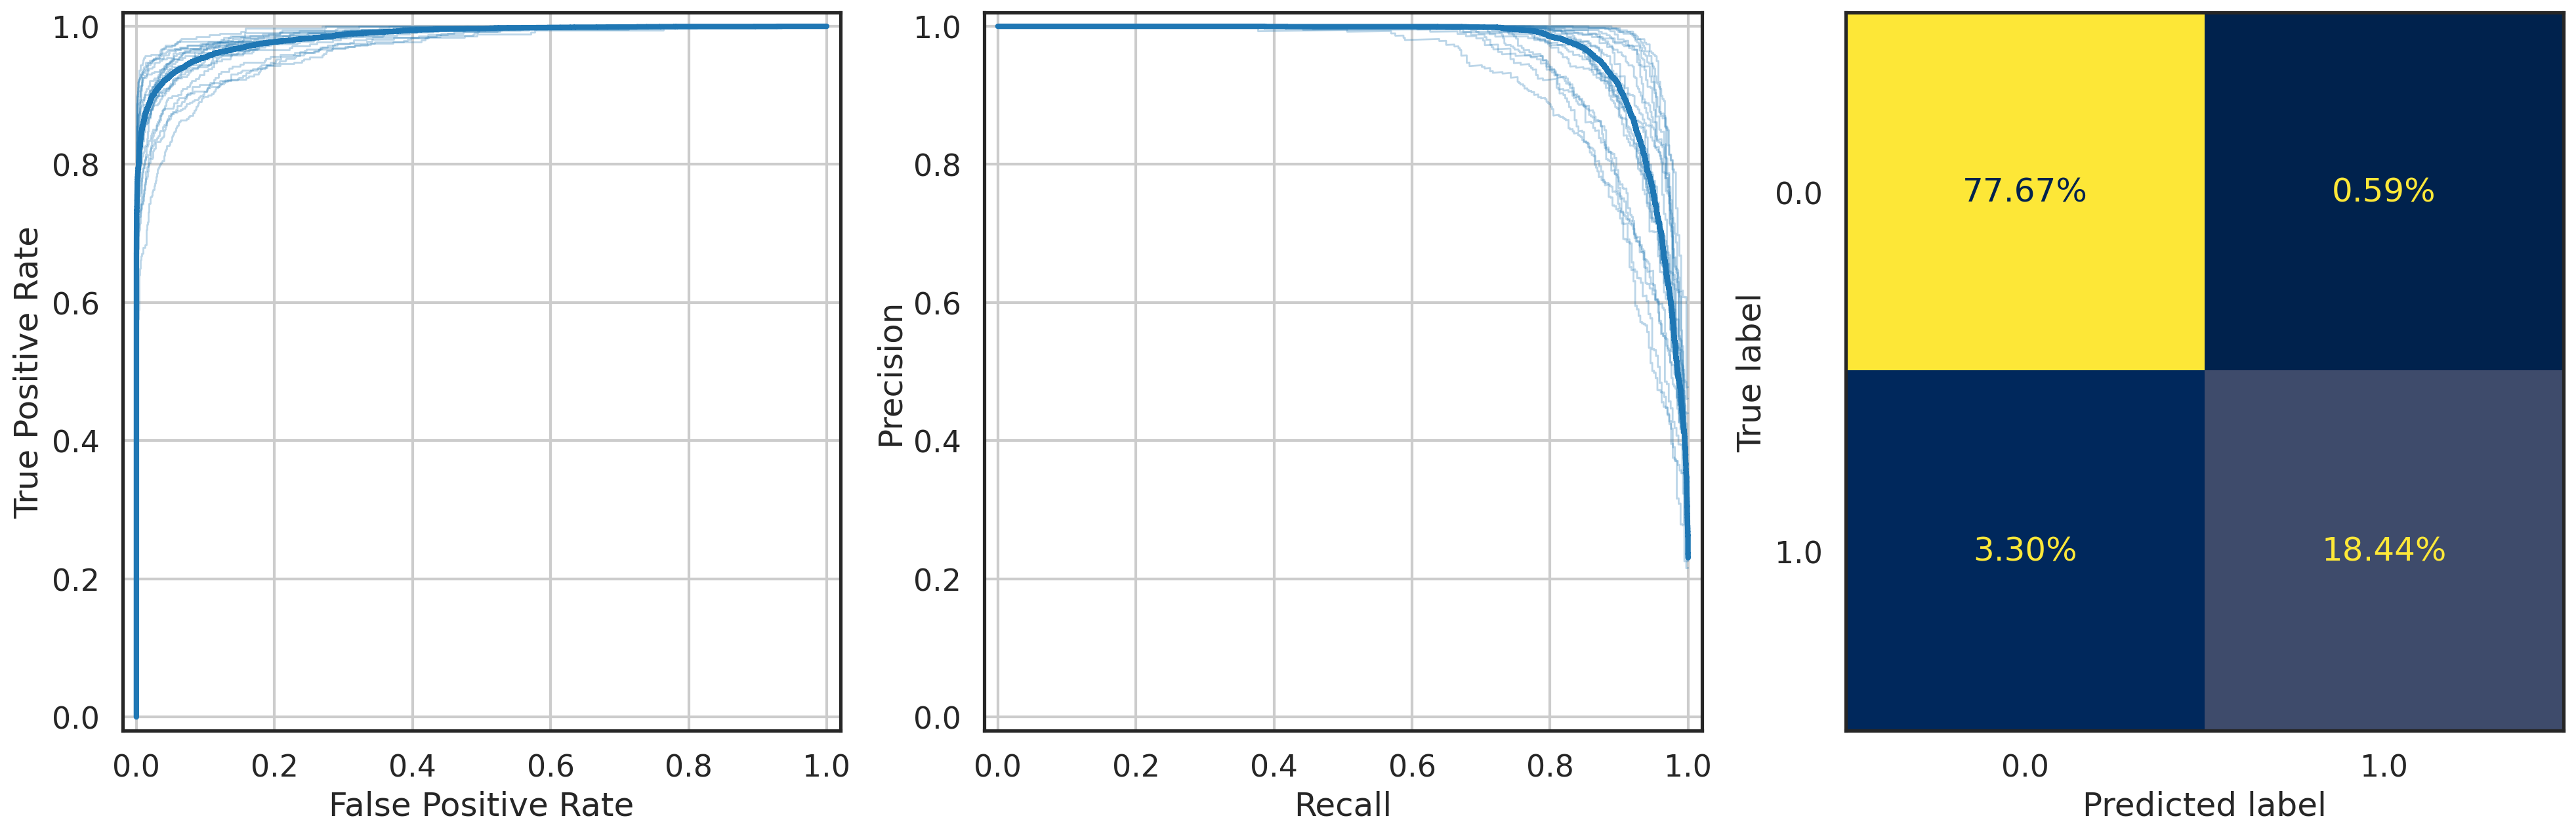

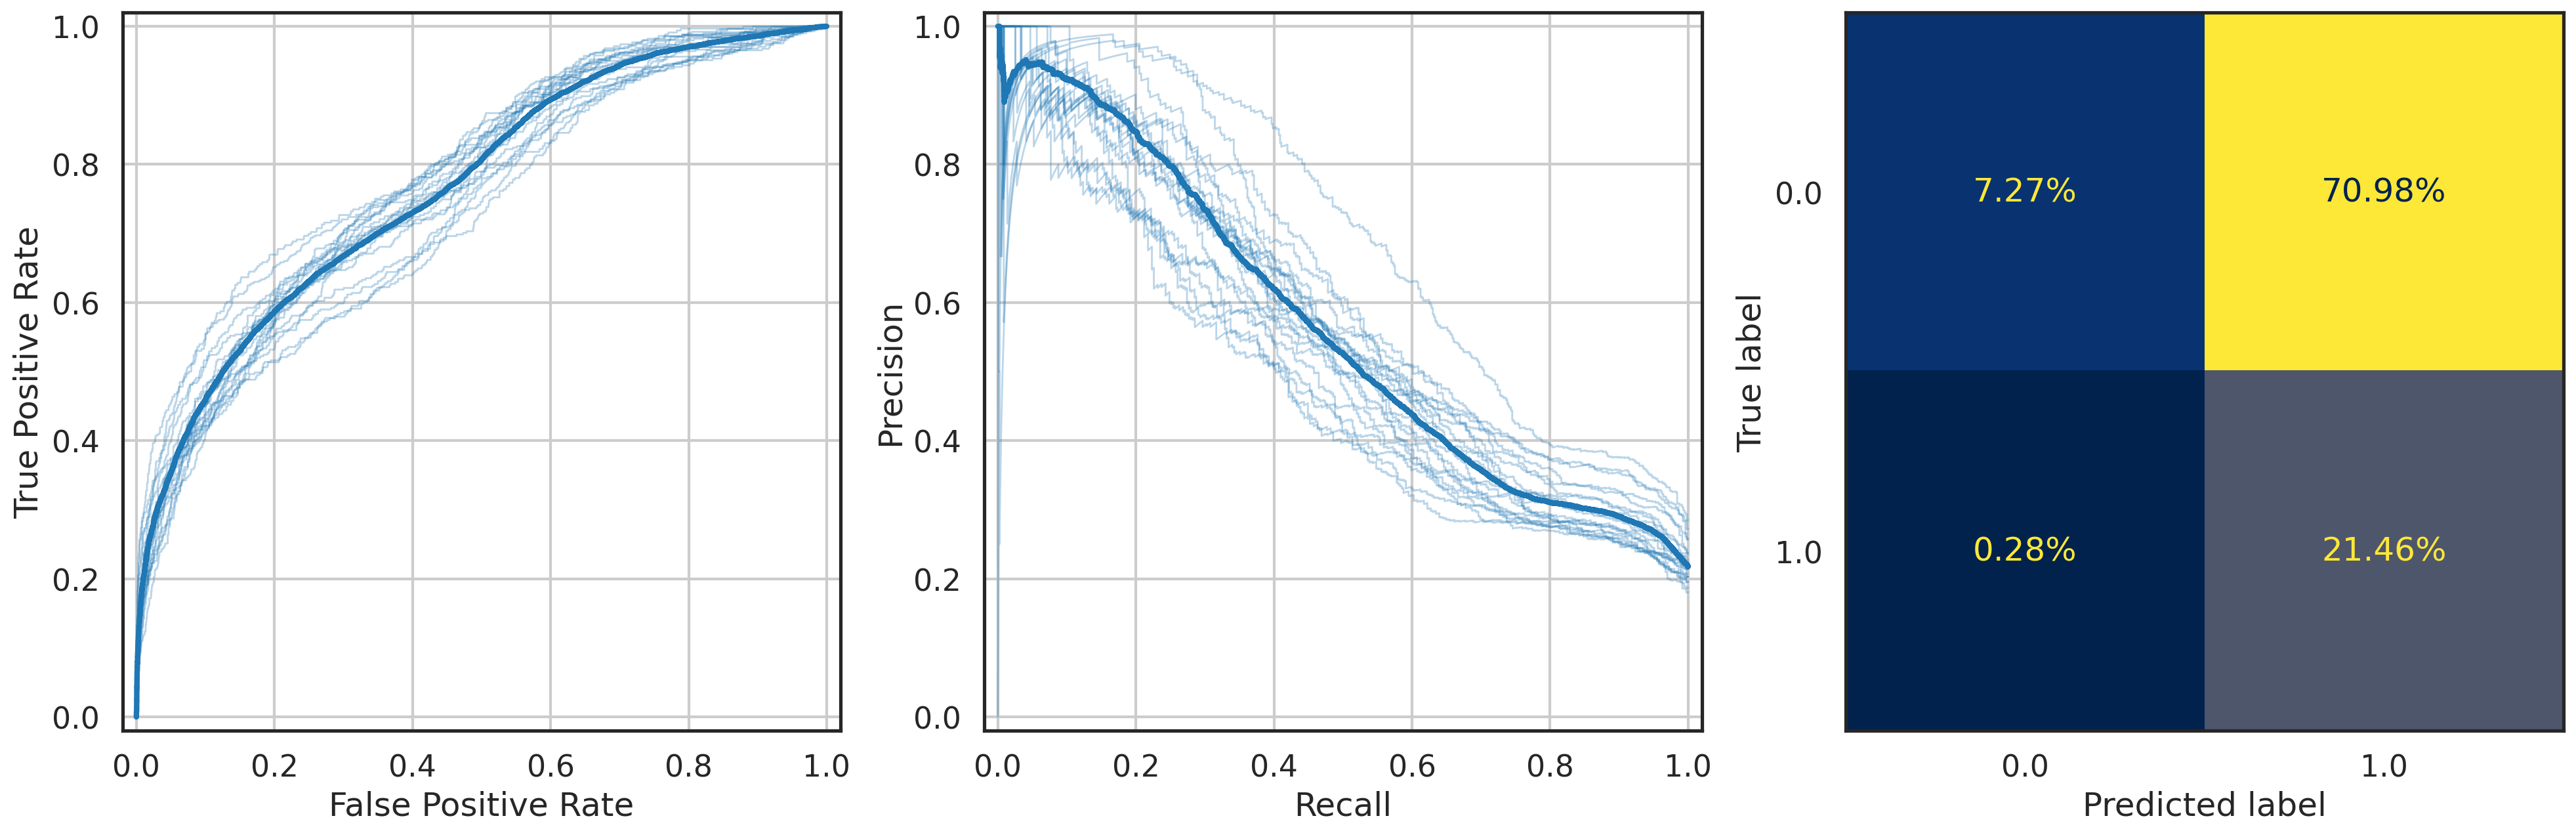

In [6]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_good=Y_te_good, Y_te_rand=Y_te_rand))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto, save=base+'/test.png')
print(report(test_onto, y_te, np.array(Y_te_good), idx_te, save=base+'/%-trained'))
print(report(test_onto, y_te, np.array(Y_te_rand), idx_te, save=base+'/%-random'))